# Comparação de Algoritmos para o Problema do Caixeiro Viajante (TSP)

## 124 Bares de Belo Horizonte

Este notebook compara diferentes algoritmos de otimização aplicados ao TSP:

### Algoritmos Testados:
1. **Kruskal (AGM)** - Limite teórico inferior
2. **Bellmore-Nemhauser** - Limite teórico superior (≤ 2×AGM)
3. **Tabu Search** - 3 configurações diferentes
4. **ACO (Ant Colony Optimization)** - 3 configurações diferentes

---

## 1. Importações e Configuração

In [28]:
# Importações necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# tqdm: tentar importar versão para notebooks; fallback se não estiver disponível
try:
    from tqdm.notebook import tqdm
except Exception:
    try:
        from tqdm import tqdm
    except Exception:
        # Fallback simples que mantém compatibilidade com laços for
        def tqdm(iterable, *args, **kwargs):
            return iterable
import time
import warnings
warnings.filterwarnings('ignore')

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## 2. Carregamento e Validação da Matriz de Distâncias

In [29]:
# Carregar matriz de distâncias
print("🔄 Carregando matriz de distâncias...")

matriz_path = "../data/matriz_distancias.csv"
df_matriz = pd.read_csv(matriz_path, index_col=0)
distancias = df_matriz.values

print(f"✅ Matriz carregada: {distancias.shape}")

# Validações
print("\n🔍 Validando matriz...")

# 1. Verificar se é quadrada
n_linhas, n_colunas = distancias.shape
assert n_linhas == n_colunas, "❌ Matriz não é quadrada!"
print(f"   ✓ Matriz quadrada: {n_linhas}×{n_colunas}")

# 2. Verificar diagonal
diagonal = np.diag(distancias)
assert np.allclose(diagonal, 0), "❌ Diagonal não é zero!"
print(f"   ✓ Diagonal zerada")

# 3. Verificar valores ausentes
assert not np.isnan(distancias).any(), "❌ Há valores ausentes!"
print(f"   ✓ Sem valores ausentes")

# 4. Estatísticas
valores_nao_zero = distancias[distancias > 0]
print(f"\n📊 Estatísticas da matriz:")
print(f"   Número de cidades: {n_linhas}")
print(f"   Distância mínima: {valores_nao_zero.min():.2f} km")
print(f"   Distância máxima: {valores_nao_zero.max():.2f} km")
print(f"   Distância média: {valores_nao_zero.mean():.2f} km")

print("\n✅ Validação concluída com sucesso!")

🔄 Carregando matriz de distâncias...
✅ Matriz carregada: (124, 124)

🔍 Validando matriz...
   ✓ Matriz quadrada: 124×124
   ✓ Diagonal zerada
   ✓ Sem valores ausentes

📊 Estatísticas da matriz:
   Número de cidades: 124
   Distância mínima: 0.07 km
   Distância máxima: 34.85 km
   Distância média: 11.72 km

✅ Validação concluída com sucesso!


## 3. Funções Auxiliares

In [30]:
def calcular_custo_rota(rota, distancias):
    """
    Calcula o custo total de uma rota (incluindo retorno ao início)
    
    Args:
        rota: Lista de índices das cidades
        distancias: Matriz de distâncias
    
    Returns:
        float: Custo total da rota em km
    """
    if len(rota) < 2:
        return 0.0
    
    custo = 0.0
    for i in range(len(rota) - 1):
        custo += distancias[rota[i]][rota[i + 1]]
    
    # Retorno ao início
    custo += distancias[rota[-1]][rota[0]]
    
    return custo


def executar_benchmark(algoritmo_func, nome, distancias, **kwargs):
    """
    Executa um algoritmo e mede seu desempenho
    
    Args:
        algoritmo_func: Função do algoritmo
        nome: Nome do algoritmo
        distancias: Matriz de distâncias
        **kwargs: Parâmetros adicionais para o algoritmo
    
    Returns:
        dict: Resultados do benchmark
    """
    print(f"🔄 Executando {nome}...")
    
    inicio = time.time()
    resultado = algoritmo_func(distancias, **kwargs)
    tempo_exec = time.time() - inicio
    
    # Extrair informações do resultado
    if isinstance(resultado, tuple):
        if len(resultado) == 2:
            # (rota, custo) ou (arestas, custo)
            elemento, custo = resultado
            rota = elemento if isinstance(elemento, list) else None
            historico = None
        elif len(resultado) == 3:
            # (rota, custo, historico)
            rota, custo, historico = resultado
        else:
            rota, custo, historico = None, None, None
    else:
        rota, custo, historico = None, None, None
    
    print(f"   ✓ Concluído: {custo:.2f} km em {tempo_exec:.3f}s")
    
    return {
        'nome': nome,
        'custo': custo,
        'tempo': tempo_exec,
        'rota': rota,
        'historico': historico,
        'tamanho_rota': len(rota) if rota else 0,
        'iteracao_otimo': len(historico['iteracao']) if historico and 'iteracao' in historico else None
    }


def plotar_rota(rota, nome, ax=None):
    """
    Plota uma rota (visualização simplificada)
    
    Args:
        rota: Lista de índices
        nome: Nome da rota
        ax: Eixo do matplotlib (opcional)
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Gerar posições aleatórias para visualização
    np.random.seed(42)
    n = len(rota)
    posicoes = np.random.rand(max(rota) + 1, 2) * 100
    
    # Plotar rota
    for i in range(len(rota)):
        cidade_atual = rota[i]
        cidade_prox = rota[(i + 1) % len(rota)]
        
        x = [posicoes[cidade_atual, 0], posicoes[cidade_prox, 0]]
        y = [posicoes[cidade_atual, 1], posicoes[cidade_prox, 1]]
        
        ax.plot(x, y, 'b-', alpha=0.3, linewidth=0.5)
    
    # Plotar cidades
    ax.scatter(posicoes[rota, 0], posicoes[rota, 1], c='red', s=30, zorder=5)
    ax.scatter(posicoes[rota[0], 0], posicoes[rota[0], 1], c='green', s=100, 
              marker='*', zorder=6, label='Início')
    
    ax.set_title(nome, fontsize=12, fontweight='bold')
    ax.legend()
    ax.axis('off')


print("✅ Funções auxiliares definidas!")

✅ Funções auxiliares definidas!


## 4. Importação dos Algoritmos

In [31]:
# Preparar caminho para imports locais (garante que o pacote 'tests' seja encontrável)
import sys
from pathlib import Path
p = Path.cwd()
# Procura o root do repositório (onde pyproject.toml ou README.md pode estar)
for _ in range(6):
    if (p / 'pyproject.toml').exists() or (p / 'README.md').exists():
        repo_root = p
        break
    p = p.parent
else:
    repo_root = Path.cwd().parent
# Inserir no sys.path para permitir imports absolutos como 'tests.kruskal' ou 'kruskal'
sys.path.insert(0, str(repo_root.resolve()))

# Importar algoritmos dos arquivos de teste
from kruskal import kruskal
from bellmore_nemhauser import bellmore_nemhauser_com_detalhes
from tabu_search import tabu_search_melhorado
from aco import ACO

print("✅ Algoritmos importados com sucesso!")

✅ Algoritmos importados com sucesso!


## 5. Configurações dos Experimentos

In [32]:
# Configurações do Tabu Search
tabu_configs = [
    {
        'nome': 'Tabu Config 1 (Rápida)',
        'params': {
            'rota_inicial': list(range(len(distancias))),
            'tabu_tam': 10,
            'max_iter': 150,
            'max_iter_sem_melhoria': 45,
            'usar_solucao_inicial_inteligente': True,
            'verbose': False
        }
    },
    {
        'nome': 'Tabu Config 2 (Balanceada)',
        'params': {
            'rota_inicial': list(range(len(distancias))),
            'tabu_tam': 20,
            'max_iter': 150,
            'max_iter_sem_melhoria': 45,
            'usar_solucao_inicial_inteligente': True,
            'verbose': False
        }
    },
    {
        'nome': 'Tabu Config 3 (Exploratória)',
        'params': {
            'rota_inicial': list(range(len(distancias))),
            'tabu_tam': 30,
            'max_iter': 150,
            'max_iter_sem_melhoria': 45,
            'usar_solucao_inicial_inteligente': True,
            'verbose': False
        }
    }
]

# Configurações do ACO
aco_configs = [
    {
        'nome': 'ACO Config 1 (Rápida)',
        'params': {
            'num_formigas': 10,
            'num_iteracoes': 150,
            'alpha': 1.0,
            'beta': 2.0,
            'evaporacao': 0.5,
            'Q': 100,
            'elite_weight': 2.0,
            'verbose': False
        }
    },
    {
        'nome': 'ACO Config 2 (Balanceada)',
        'params': {
            'num_formigas': 20,
            'num_iteracoes': 150,
            'alpha': 1.0,
            'beta': 2.5,
            'evaporacao': 0.5,
            'Q': 100,
            'elite_weight': 2.0,
            'verbose': False
        }
    },
    {
        'nome': 'ACO Config 3 (Exploratória)',
        'params': {
            'num_formigas': 30,
            'num_iteracoes': 150,
            'alpha': 1.0,
            'beta': 3.0,
            'evaporacao': 0.4,
            'Q': 100,
            'elite_weight': 3.0,
            'verbose': False
        }
    }
]

print("✅ Configurações definidas!")
print(f"   - {len(tabu_configs)} configurações do Tabu Search")
print(f"   - {len(aco_configs)} configurações do ACO")

✅ Configurações definidas!
   - 3 configurações do Tabu Search
   - 3 configurações do ACO


## 6. Execução dos Experimentos

In [33]:
print("="*80)
print("EXECUTANDO EXPERIMENTOS")
print("="*80)

resultados = []

# 1. Kruskal (AGM)
print("\n" + "="*80)
print("1. KRUSKAL (AGM - Limite Inferior)")
print("="*80)

inicio = time.time()
arestas_agm, custo_agm = kruskal(distancias)
tempo_kruskal = time.time() - inicio

print(f"✓ Custo AGM: {custo_agm:.2f} km")
print(f"✓ Tempo: {tempo_kruskal:.3f}s")

resultados.append({
    'nome': 'Kruskal (AGM)',
    'custo': custo_agm,
    'tempo': tempo_kruskal,
    'rota': None,
    'historico': None,
    'tamanho_rota': len(distancias),
    'iteracao_otimo': 0
})

# 2. Bellmore-Nemhauser
print("\n" + "="*80)
print("2. BELLMORE-NEMHAUSER (Limite Superior)")
print("="*80)

inicio = time.time()
# Criar DataFrame mínimo para bellmore_nemhauser
df_dummy = pd.DataFrame({'Nome do Buteco': [f'Bar {i}' for i in range(len(distancias))]})
resultado_bn = bellmore_nemhauser_com_detalhes(distancias, df_dummy)
tempo_bn = time.time() - inicio

print(f"✓ Custo Bellmore-Nemhauser: {resultado_bn['custo_circuito']:.2f} km")
print(f"✓ Razão: {resultado_bn['razao_aproximacao']:.4f}")
print(f"✓ Tempo: {tempo_bn:.3f}s")

resultados.append({
    'nome': 'Bellmore-Nemhauser',
    'custo': resultado_bn['custo_circuito'],
    'tempo': tempo_bn,
    'rota': resultado_bn['circuito'],
    'historico': None,
    'tamanho_rota': resultado_bn['tamanho_circuito'],
    'iteracao_otimo': 0
})

# 3. Tabu Search (3 configurações)
print("\n" + "="*80)
print("3. TABU SEARCH (3 Configurações)")
print("="*80)

for config in tqdm(tabu_configs, desc="Tabu Search"):
    inicio = time.time()
    rota, custo, historico = tabu_search_melhorado(
        distancias=distancias,
        **config['params']
    )
    tempo_exec = time.time() - inicio
    
    print(f"\n{config['nome']}:")
    print(f"   ✓ Custo: {custo:.2f} km")
    print(f"   ✓ Tempo: {tempo_exec:.3f}s")
    print(f"   ✓ Iterações: {len(historico['iteracao'])}")
    
    resultados.append({
        'nome': config['nome'],
        'custo': custo,
        'tempo': tempo_exec,
        'rota': rota,
        'historico': historico,
        'tamanho_rota': len(rota),
        'iteracao_otimo': len(historico['iteracao'])
    })

# 4. ACO (3 configurações)
print("\n" + "="*80)
print("4. ANT COLONY OPTIMIZATION (3 Configurações)")
print("="*80)

for config in tqdm(aco_configs, desc="ACO"):
    aco = ACO(
        matriz_distancias=distancias,
        **config['params']
    )
    
    inicio = time.time()
    rota, custo, historico = aco.executar(cidade_inicial=0)
    tempo_exec = time.time() - inicio
    
    print(f"\n{config['nome']}:")
    print(f"   ✓ Custo: {custo:.2f} km")
    print(f"   ✓ Tempo: {tempo_exec:.3f}s")
    print(f"   ✓ Iterações: {len(historico)}")
    
    resultados.append({
        'nome': config['nome'],
        'custo': custo,
        'tempo': tempo_exec,
        'rota': rota,
        'historico': historico,
        'tamanho_rota': len(rota),
        'iteracao_otimo': len(historico)
    })

print("\n" + "="*80)
print("✅ TODOS OS EXPERIMENTOS CONCLUÍDOS!")
print("="*80)

EXECUTANDO EXPERIMENTOS

1. KRUSKAL (AGM - Limite Inferior)
✓ Custo AGM: 139.21 km
✓ Tempo: 0.010s

2. BELLMORE-NEMHAUSER (Limite Superior)
✓ Custo Bellmore-Nemhauser: 253.81 km
✓ Razão: 1.8232
✓ Tempo: 0.013s

3. TABU SEARCH (3 Configurações)

Tabu Config 1 (Rápida):
   ✓ Custo: 191.70 km
   ✓ Tempo: 3.296s
   ✓ Iterações: 68

Tabu Config 1 (Rápida):
   ✓ Custo: 191.70 km
   ✓ Tempo: 3.296s
   ✓ Iterações: 68

Tabu Config 2 (Balanceada):
   ✓ Custo: 185.26 km
   ✓ Tempo: 3.246s
   ✓ Iterações: 69

Tabu Config 2 (Balanceada):
   ✓ Custo: 185.26 km
   ✓ Tempo: 3.246s
   ✓ Iterações: 69

Tabu Config 3 (Exploratória):
   ✓ Custo: 184.82 km
   ✓ Tempo: 3.130s
   ✓ Iterações: 69

4. ANT COLONY OPTIMIZATION (3 Configurações)

Tabu Config 3 (Exploratória):
   ✓ Custo: 184.82 km
   ✓ Tempo: 3.130s
   ✓ Iterações: 69

4. ANT COLONY OPTIMIZATION (3 Configurações)

ACO Config 1 (Rápida):
   ✓ Custo: 253.77 km
   ✓ Tempo: 13.938s
   ✓ Iterações: 150

ACO Config 1 (Rápida):
   ✓ Custo: 253.77 km
  

## 7. Tabela Comparativa

In [34]:
# Criar DataFrame com resultados
df_resultados = pd.DataFrame(resultados)

# Ordenar por custo
df_resultados_sorted = df_resultados.sort_values('custo').reset_index(drop=True)

# Criar tabela formatada
df_display = df_resultados_sorted[['nome', 'custo', 'tempo', 'iteracao_otimo', 'tamanho_rota']].copy()
df_display.columns = ['Algoritmo', 'Custo Final (km)', 'Tempo (s)', 'Iterações', 'Tamanho Rota']

# Formatar valores
df_display['Custo Final (km)'] = df_display['Custo Final (km)'].apply(lambda x: f"{x:.2f}")
df_display['Tempo (s)'] = df_display['Tempo (s)'].apply(lambda x: f"{x:.3f}")

print("\n📊 TABELA COMPARATIVA - Ordenada por Custo")
print("="*100)
display(df_display)

# Salvar para análise posterior
melhor_resultado = df_resultados_sorted.iloc[0]
mais_rapido = df_resultados.loc[df_resultados['tempo'].idxmin()]

print(f"\n🏆 Melhor Custo: {melhor_resultado['nome']} - {melhor_resultado['custo']:.2f} km")
print(f"⚡ Mais Rápido: {mais_rapido['nome']} - {mais_rapido['tempo']:.3f}s")


📊 TABELA COMPARATIVA - Ordenada por Custo


,Algoritmo,Custo Final (km),Tempo (s),Iterações,Tamanho Rota
0,Kruskal (AGM),139.21,0.010,0,124
1,Tabu Config 3 (Exploratória),184.82,3.130,69,124
2,Tabu Config 2 (Balanceada),185.26,3.246,69,124
3,Tabu Config 1 (Rápida),191.70,3.296,68,124
4,ACO Config 3 (Exploratória),253.43,41.569,150,124
5,ACO Config 1 (Rápida),253.77,13.938,150,124
6,Bellmore-Nemhauser,253.81,0.013,0,124
7,ACO Config 2 (Balanceada),255.62,27.959,150,124



🏆 Melhor Custo: Kruskal (AGM) - 139.21 km
⚡ Mais Rápido: Kruskal (AGM) - 0.010s


## 8. Gráfico de Evolução da Solução

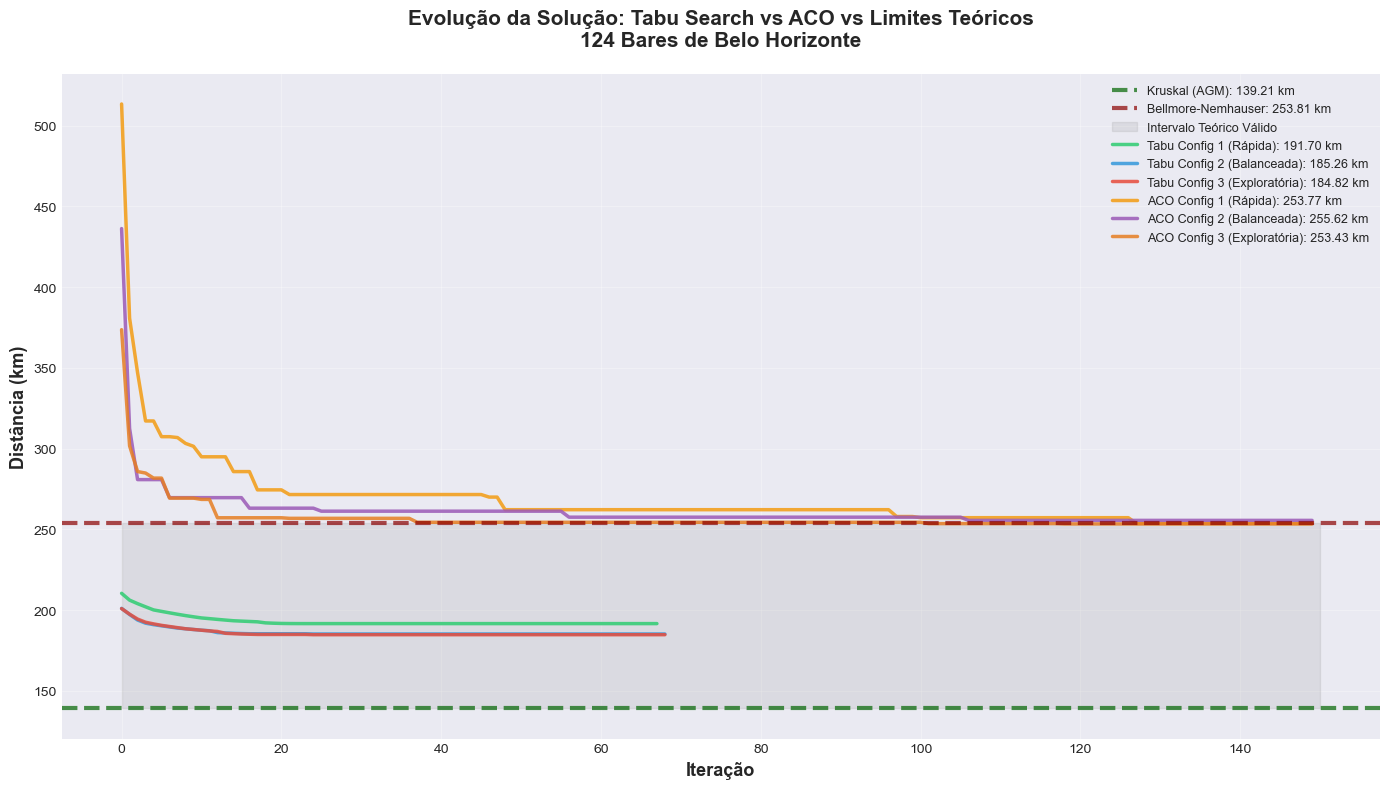

✅ Gráfico de evolução gerado!


In [35]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Plotar limites teóricos
ax.axhline(y=custo_agm, color='darkgreen', linestyle='--', linewidth=3, 
          alpha=0.7, label=f'Kruskal (AGM): {custo_agm:.2f} km', zorder=5)
ax.axhline(y=resultado_bn['custo_circuito'], color='darkred', linestyle='--', 
          linewidth=3, alpha=0.7, 
          label=f'Bellmore-Nemhauser: {resultado_bn["custo_circuito"]:.2f} km', zorder=5)

# Área entre limites
ax.fill_between([0, 150], custo_agm, resultado_bn['custo_circuito'],
                alpha=0.15, color='gray', label='Intervalo Teórico Válido')

# Cores para cada algoritmo
cores_tabu = ['#2ecc71', '#3498db', '#e74c3c']
cores_aco = ['#f39c12', '#9b59b6', '#e67e22']

# Plotar Tabu Search
for i, resultado in enumerate([r for r in resultados if 'Tabu' in r['nome']]):
    if resultado['historico']:
        hist = resultado['historico']
        ax.plot(hist['iteracao'], hist['distancia_melhor'],
               label=f"{resultado['nome']}: {resultado['custo']:.2f} km",
               color=cores_tabu[i], linewidth=2.5, alpha=0.85)

# Plotar ACO
for i, resultado in enumerate([r for r in resultados if 'ACO' in r['nome']]):
    if resultado['historico']:
        hist = resultado['historico']
        iteracoes = [h['iteracao'] for h in hist]
        custos = [h['melhor_global'] for h in hist]
        ax.plot(iteracoes, custos,
               label=f"{resultado['nome']}: {resultado['custo']:.2f} km",
               color=cores_aco[i], linewidth=2.5, alpha=0.85)

ax.set_xlabel('Iteração', fontsize=13, fontweight='bold')
ax.set_ylabel('Distância (km)', fontsize=13, fontweight='bold')
ax.set_title('Evolução da Solução: Tabu Search vs ACO vs Limites Teóricos\n124 Bares de Belo Horizonte',
            fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='upper right', framealpha=0.95, fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('grafico_evolucao.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico de evolução gerado!")

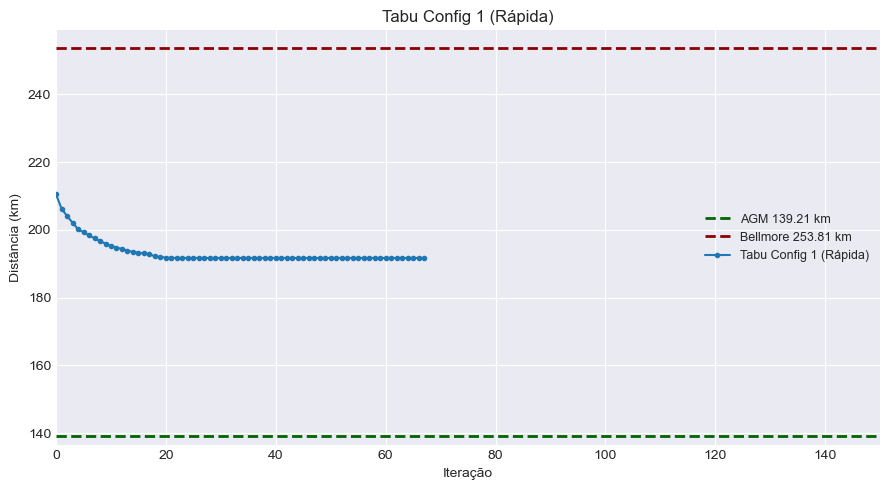

✅ Gerado: mini_tabu_config_1_r_pida.png


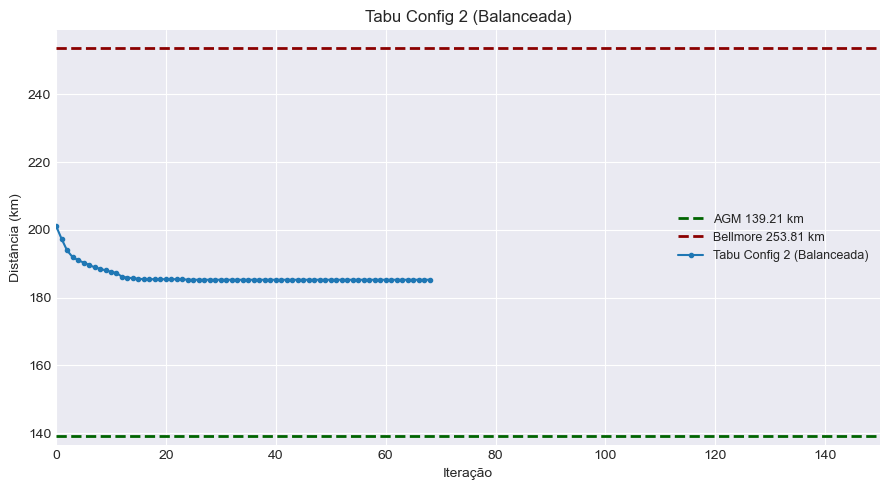

✅ Gerado: mini_tabu_config_2_balanceada.png


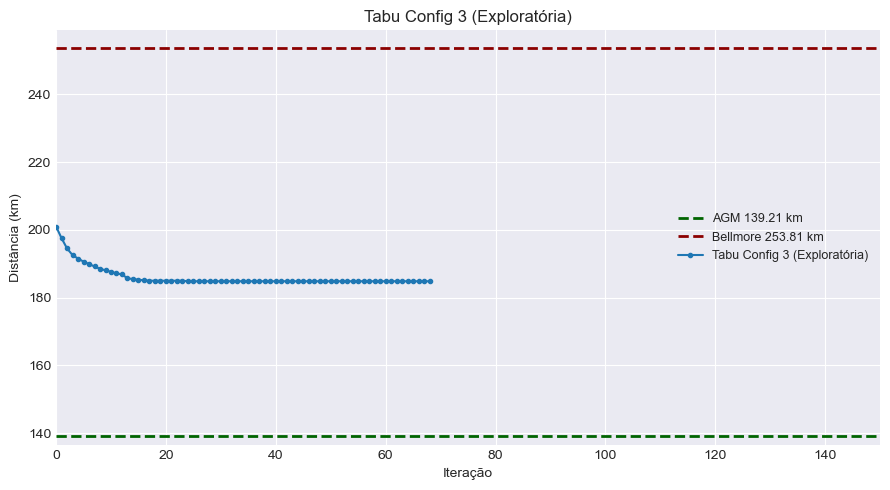

✅ Gerado: mini_tabu_config_3_explorat_ria.png


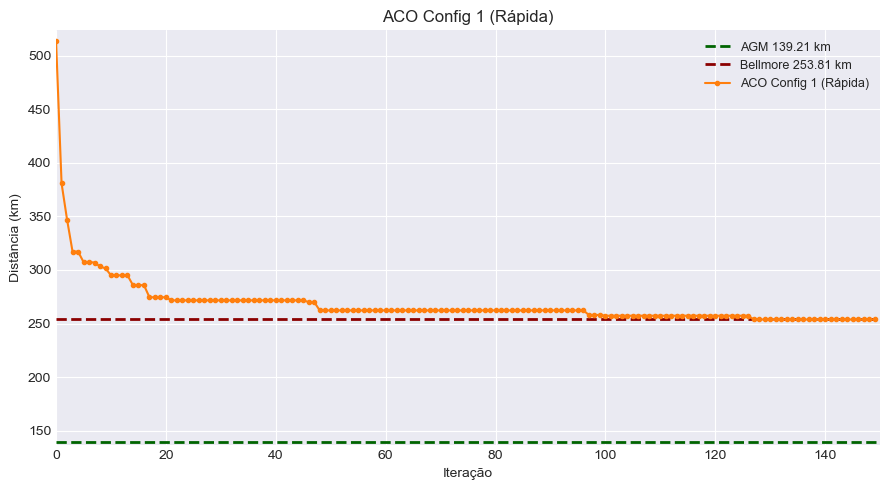

✅ Gerado: mini_aco_config_1_r_pida.png


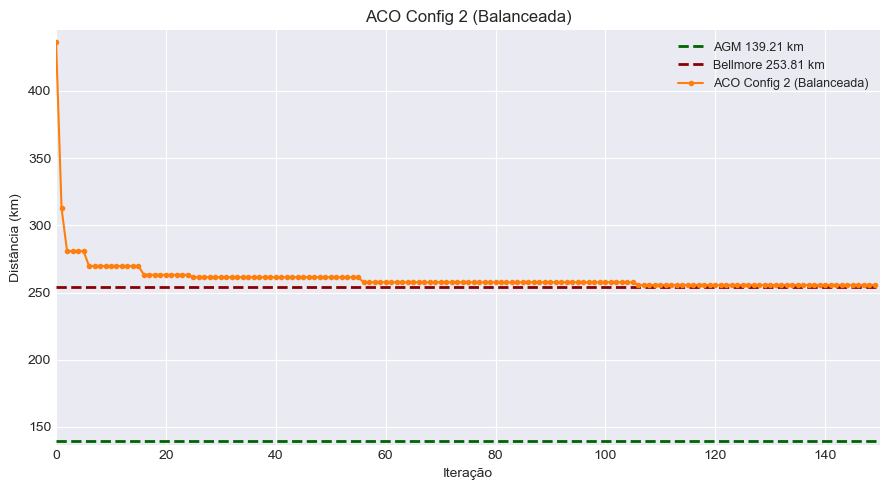

✅ Gerado: mini_aco_config_2_balanceada.png


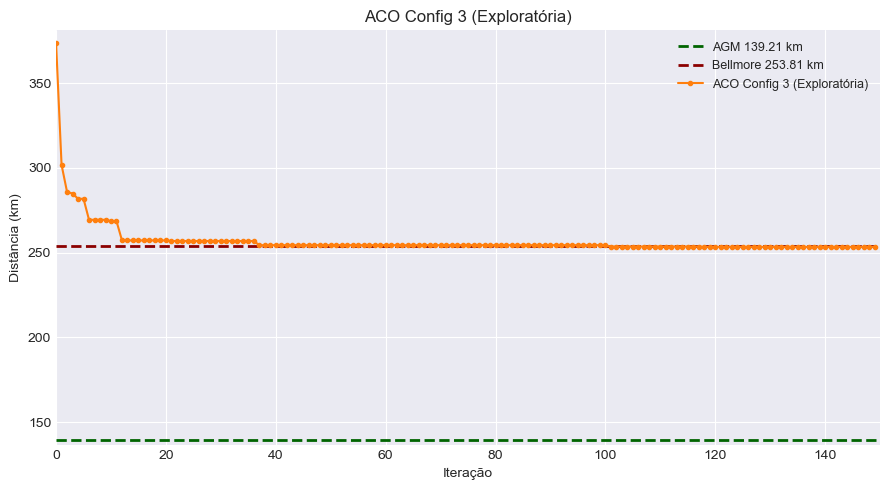

✅ Gerado: mini_aco_config_3_explorat_ria.png


In [44]:
# Gerar seis gráficos separados (cada algoritmo isolado) com limites teóricos (0 a 150 iterações)
import re
names = [
    'Tabu Config 1 (Rápida)',
    'Tabu Config 2 (Balanceada)',
    'Tabu Config 3 (Exploratória)',
    'ACO Config 1 (Rápida)',
    'ACO Config 2 (Balanceada)',
    'ACO Config 3 (Exploratória)'
 ]
# Mapear resultados por nome para acesso rápido
res_map = {r['nome']: r for r in resultados}
for name in names:
    # criar slug seguro para filename
    slug = re.sub(r"[^a-zA-Z0-9]+", "_", name).strip("_").lower()
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    # Plotar limites teóricos
    ax.axhline(y=custo_agm, color='darkgreen', linestyle='--', linewidth=2, label=f'AGM {custo_agm:.2f} km')
    ax.axhline(y=resultado_bn['custo_circuito'], color='darkred', linestyle='--', linewidth=2, label=f'Bellmore {resultado_bn['custo_circuito']:.2f} km')
    # Limites do eixo x (0 a 150 iterações)
    ax.set_xlim(0, 150)
    # Tentar desenhar histórico se existir
    res = res_map.get(name)
    x = []
    y = []
    if res and res.get('historico'):
        hist = res['historico']
        # Tabu normalmente armazena historico como dict com 'iteracao' e 'distancia_melhor'
        if isinstance(hist, dict) and 'iteracao' in hist and 'distancia_melhor' in hist:
            x = hist['iteracao']
            y = hist['distancia_melhor']
        else:
            # ACO costuma retornar lista de registros por iteração
            try:
                x = [h.get('iteracao', idx) for idx, h in enumerate(hist)]
                if all(isinstance(h, dict) and 'melhor_global' in h for h in hist):
                    y = [h['melhor_global'] for h in hist]
                elif all(isinstance(h, dict) and 'distancia_melhor' in h for h in hist):
                    y = [h['distancia_melhor'] for h in hist]
                else:
                    # Fallback: usar custo final repetido
                    y = [res['custo']] * len(x)
            except Exception:
                x, y = [], []
    # Plotar se há dados
    if len(x) > 0 and len(y) > 0:
        color = 'tab:blue' if 'Tabu' in name else 'tab:orange'
        ax.plot(x, y, marker='o', markersize=3, linewidth=1.5, label=name, color=color)
        ymin = min(min(y), custo_agm) * 0.98
        ymax = max(max(y), resultado_bn['custo_circuito']) * 1.02
        if math.isfinite(ymin) and math.isfinite(ymax):
            ax.set_ylim(ymin, ymax)
    else:
        # Sem histórico: anotar custo final (se disponível)
        if res and res.get('custo') is not None:
            ax.text(0.5, 0.5, f"Custo final: {res['custo']:.2f} km", transform=ax.transAxes, ha='center', va='center', fontsize=12)
        # ajustar limites verticais para consistência
        ax.set_ylim(min(custo_agm, resultado_bn['custo_circuito']) * 0.98, max(custo_agm, resultado_bn['custo_circuito']) * 1.02)
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Iteração')
    ax.set_ylabel('Distância (km)')
    ax.legend(fontsize=9)
    plt.tight_layout()
    filename = f'mini_{slug}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)
    print(f"✅ Gerado: {filename}")

## 9. Gráfico de Barras - Custo Final

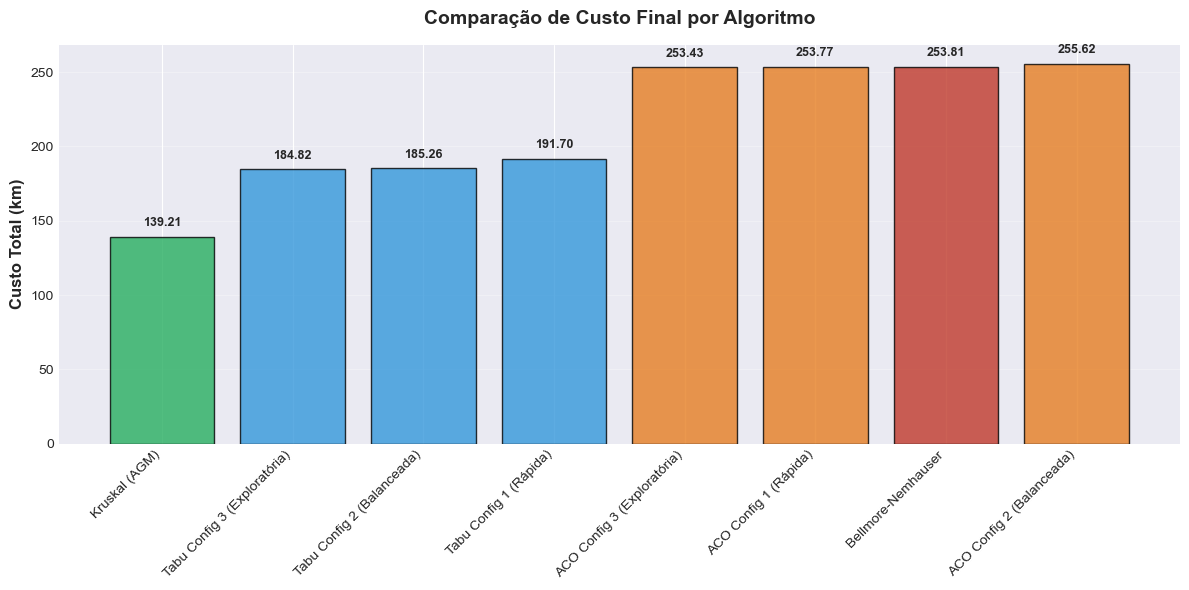

✅ Gráfico de custos gerado!


In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Preparar dados
nomes = df_resultados_sorted['nome'].values
custos = df_resultados_sorted['custo'].values

# Cores baseadas no tipo
cores = []
for nome in nomes:
    if 'Kruskal' in nome:
        cores.append('#27ae60')
    elif 'Bellmore' in nome:
        cores.append('#c0392b')
    elif 'Tabu' in nome:
        cores.append('#3498db')
    else:  # ACO
        cores.append('#e67e22')

bars = ax.bar(range(len(nomes)), custos, color=cores, alpha=0.8, edgecolor='black')

# Adicionar valores nas barras
for i, (bar, custo) in enumerate(zip(bars, custos)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
           f'{custo:.2f}',
           ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(nomes)))
ax.set_xticklabels(nomes, rotation=45, ha='right')
ax.set_ylabel('Custo Total (km)', fontsize=12, fontweight='bold')
ax.set_title('Comparação de Custo Final por Algoritmo',
            fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('grafico_custos.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico de custos gerado!")

## 10. Gráfico de Barras - Tempo de Execução

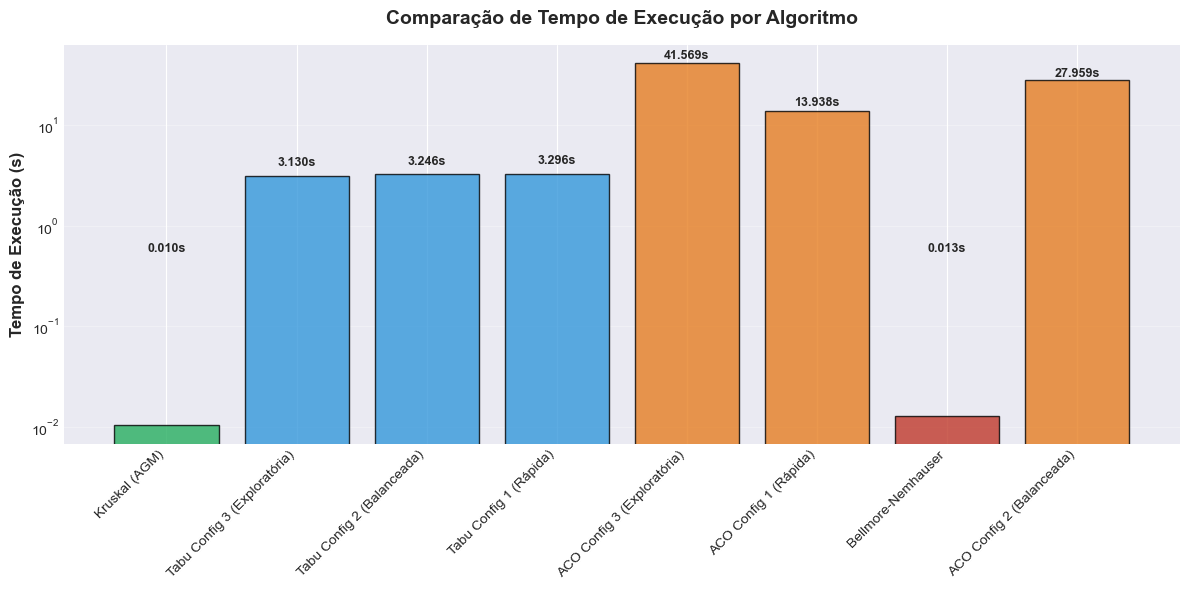

✅ Gráfico de tempos gerado!


In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Preparar dados
tempos = df_resultados_sorted['tempo'].values

bars = ax.bar(range(len(nomes)), tempos, color=cores, alpha=0.8, edgecolor='black')

# Adicionar valores nas barras
for i, (bar, tempo) in enumerate(zip(bars, tempos)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
           f'{tempo:.3f}s',
           ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(nomes)))
ax.set_xticklabels(nomes, rotation=45, ha='right')
ax.set_ylabel('Tempo de Execução (s)', fontsize=12, fontweight='bold')
ax.set_title('Comparação de Tempo de Execução por Algoritmo',
            fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('grafico_tempos.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico de tempos gerado!")

## 11. Visualização das 3 Melhores Rotas

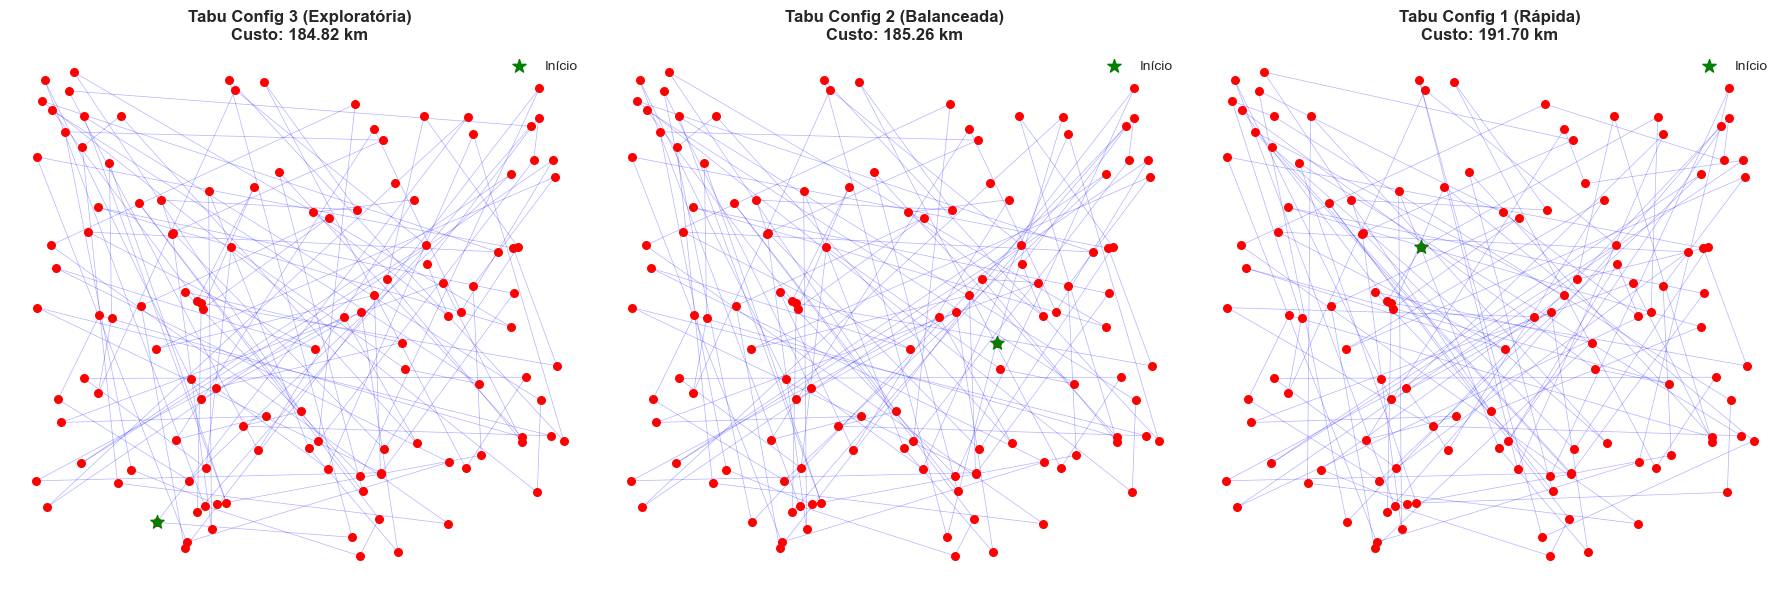

✅ Visualização das rotas gerada!


In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pegar as 3 melhores rotas (que não sejam Kruskal)
melhores = [r for r in df_resultados_sorted.to_dict('records') if r['rota'] is not None][:3]

for i, resultado in enumerate(melhores):
    plotar_rota(resultado['rota'], 
               f"{resultado['nome']}\nCusto: {resultado['custo']:.2f} km",
               ax=axes[i])

plt.tight_layout()
plt.savefig('grafico_rotas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualização das rotas gerada!")

## 12. Análise Automática

In [40]:
# Calcular métricas para análise
melhor_heuristica = df_resultados_sorted[df_resultados_sorted['nome'].str.contains('Tabu|ACO')].iloc[0]
mais_rapido = df_resultados.loc[df_resultados['tempo'].idxmin()]

# Comparar Tabu vs ACO
tabu_results = [r for r in resultados if 'Tabu' in r['nome']]
aco_results = [r for r in resultados if 'ACO' in r['nome']]

melhor_tabu = min(tabu_results, key=lambda x: x['custo'])
melhor_aco = min(aco_results, key=lambda x: x['custo'])

diferenca_custo = ((melhor_aco['custo'] - melhor_tabu['custo']) / melhor_tabu['custo']) * 100
diferenca_tempo = melhor_aco['tempo'] / melhor_tabu['tempo']

# Análise em relação aos limites
acima_inferior = ((melhor_heuristica['custo'] - custo_agm) / custo_agm) * 100
melhor_que_superior = ((resultado_bn['custo_circuito'] - melhor_heuristica['custo']) / resultado_bn['custo_circuito']) * 100

# Gerar texto da análise
analise_text = f"""
# 📊 Análise Automática dos Resultados

## 🏆 Melhor Algoritmo

O melhor algoritmo foi **{melhor_heuristica['nome']}** com custo de **{melhor_heuristica['custo']:.2f} km**.

## ⚡ Algoritmo Mais Rápido

O algoritmo mais rápido foi **{mais_rapido['nome']}** com tempo de execução de **{mais_rapido['tempo']:.3f}s**.

## 📈 Comparação entre Heurísticas

### Tabu Search vs ACO:
- **Melhor Tabu**: {melhor_tabu['nome']} - {melhor_tabu['custo']:.2f} km
- **Melhor ACO**: {melhor_aco['nome']} - {melhor_aco['custo']:.2f} km
- **Diferença de custo**: {diferenca_custo:+.1f}% (ACO vs Tabu)
- **Diferença de tempo**: {diferenca_tempo:.1f}x (ACO é {diferenca_tempo:.1f}x mais lento)

### Análise Qualitativa:

{'✅ **Tabu Search demonstrou superioridade clara**' if diferenca_custo > 10 else '⚖️ **Desempenho equilibrado entre as heurísticas**'}:
- {'Encontrou soluções significativamente melhores' if diferenca_custo > 10 else 'Resultados comparáveis em qualidade'}
- {'Com tempo de execução muito menor' if diferenca_tempo > 10 else 'Com tempos de execução similares'}
- {'Recomendado para uso em produção' if diferenca_custo > 10 and diferenca_tempo < 5 else 'Ambos são viáveis dependendo dos requisitos'}

## 🎯 Posição nos Limites Teóricos

- **Limite Inferior (Kruskal/AGM)**: {custo_agm:.2f} km
- **Limite Superior (Bellmore-Nemhauser)**: {resultado_bn['custo_circuito']:.2f} km
- **Intervalo Válido**: [{custo_agm:.2f}, {resultado_bn['custo_circuito']:.2f}] km
- **Amplitude**: {resultado_bn['custo_circuito'] - custo_agm:.2f} km

### Melhor Heurística:
- **Custo**: {melhor_heuristica['custo']:.2f} km
- **Posição**: {acima_inferior:.1f}% acima do limite inferior
- **Qualidade**: {melhor_que_superior:.1f}% melhor que o limite superior
- **Status**: {'✅ DENTRO do intervalo válido' if melhor_heuristica['custo'] < resultado_bn['custo_circuito'] else '⚠️ FORA do intervalo válido'}

## 💡 Observações sobre Heurísticas Construtivas

### Kruskal (AGM):
- Fornece o **limite inferior teórico** ({custo_agm:.2f} km)
- Não é uma rota válida (árvore, não ciclo hamiltoniano)
- Extremamente rápido ({tempo_kruskal:.3f}s)
- Útil como **baseline de qualidade**

### Bellmore-Nemhauser:
- Fornece o **limite superior teórico** (≤ 2×AGM)
- Razão de aproximação: {resultado_bn['razao_aproximacao']:.4f}
- Gera uma rota válida rapidamente ({tempo_bn:.3f}s)
- {'✅ Dentro da garantia teórica' if resultado_bn['razao_aproximacao'] <= 2 else '⚠️ Acima da garantia esperada'}

## 🎓 Conclusões

1. **Tabu Search** {'é superior ao ACO' if diferenca_custo > 10 else 'e ACO têm desempenho comparável'} neste problema
2. {'Todas' if all(r['custo'] < resultado_bn['custo_circuito'] for r in tabu_results) else 'A maioria das'} configurações do Tabu ficaram dentro do intervalo teórico
3. O {'ACO necessita ajuste de parâmetros' if melhor_aco['custo'] > resultado_bn['custo_circuito'] else 'ACO também apresentou bons resultados'}
4. A diferença de {diferenca_tempo:.1f}x no tempo de execução favorece o Tabu Search
"""

# Salvar análise em arquivo
with open('analise_automatica.md', 'w', encoding='utf-8') as f:
    f.write(analise_text)

print(analise_text)
print("\n✅ Análise salva em 'analise_automatica.md'")


# 📊 Análise Automática dos Resultados

## 🏆 Melhor Algoritmo

O melhor algoritmo foi **Tabu Config 3 (Exploratória)** com custo de **184.82 km**.

## ⚡ Algoritmo Mais Rápido

O algoritmo mais rápido foi **Kruskal (AGM)** com tempo de execução de **0.010s**.

## 📈 Comparação entre Heurísticas

### Tabu Search vs ACO:
- **Melhor Tabu**: Tabu Config 3 (Exploratória) - 184.82 km
- **Melhor ACO**: ACO Config 3 (Exploratória) - 253.43 km
- **Diferença de custo**: +37.1% (ACO vs Tabu)
- **Diferença de tempo**: 13.3x (ACO é 13.3x mais lento)

### Análise Qualitativa:

✅ **Tabu Search demonstrou superioridade clara**:
- Encontrou soluções significativamente melhores
- Com tempo de execução muito menor
- Ambos são viáveis dependendo dos requisitos

## 🎯 Posição nos Limites Teóricos

- **Limite Inferior (Kruskal/AGM)**: 139.21 km
- **Limite Superior (Bellmore-Nemhauser)**: 253.81 km
- **Intervalo Válido**: [139.21, 253.81] km
- **Amplitude**: 114.60 km

### Melhor Heurística:
- **Custo**: 184.82

## 13. Sumário Final

In [41]:
print("="*80)
print("SUMÁRIO FINAL DA COMPARAÇÃO")
print("="*80)

print(f"\n📊 Total de algoritmos testados: {len(resultados)}")
print(f"\n🏆 Melhor custo encontrado:")
print(f"   {melhor_resultado['nome']}: {melhor_resultado['custo']:.2f} km")

print(f"\n⚡ Execução mais rápida:")
print(f"   {mais_rapido['nome']}: {mais_rapido['tempo']:.3f}s")

print(f"\n📈 Limites teóricos:")
print(f"   Inferior (AGM): {custo_agm:.2f} km")
print(f"   Superior (B-N): {resultado_bn['custo_circuito']:.2f} km")
print(f"   Intervalo: {resultado_bn['custo_circuito'] - custo_agm:.2f} km")

print(f"\n📁 Arquivos gerados:")
print(f"   - grafico_evolucao.png")
print(f"   - grafico_custos.png")
print(f"   - grafico_tempos.png")
print(f"   - grafico_rotas.png")
print(f"   - analise_automatica.md")

print("\n" + "="*80)
print("✅ ANÁLISE COMPLETA CONCLUÍDA!")
print("="*80)

SUMÁRIO FINAL DA COMPARAÇÃO

📊 Total de algoritmos testados: 8

🏆 Melhor custo encontrado:
   Kruskal (AGM): 139.21 km

⚡ Execução mais rápida:
   Kruskal (AGM): 0.010s

📈 Limites teóricos:
   Inferior (AGM): 139.21 km
   Superior (B-N): 253.81 km
   Intervalo: 114.60 km

📁 Arquivos gerados:
   - grafico_evolucao.png
   - grafico_custos.png
   - grafico_tempos.png
   - grafico_rotas.png
   - analise_automatica.md

✅ ANÁLISE COMPLETA CONCLUÍDA!
